# Part 1: Genres and communities and plotting

## Write about genres and modularity.

## Detect the communities, discuss the value of modularity in comparison to the genres.



In [12]:
import json
import networkx as nx
import pickle
import re


# Load genre data from infoboxes.txt
file_path_genre = '/Users/aya/Desktop/Skole/social_graps/Aya/shared/infoboxes.txt'
with open(file_path_genre, 'r') as file:
    data = json.load(file)

# Load the graph from performer_network.pkl
file_path_graph = '/Users/aya/Desktop/Skole/social_graps/Aya/shared/performer_network.pkl'
with open(file_path_graph, 'rb') as f:
    G = pickle.load(f)

G = G.to_undirected()
# Define a function to standardize genres
def standardize_genre(genre):
    genre_lower = genre.lower().strip()
    # Remove ' music' at the end if present
    genre_standard = re.sub(r'\s+music$', '', genre_lower)
    return genre_standard

# Add standardized genre attribute to each artist node in the graph
for artist, genres in data.items():
    if artist in G.nodes:  # Only update nodes that exist in the graph
        # Ensure genres is a list; if it's a string, convert it to a list
        if isinstance(genres, str):
            genres = [genres]
        # Standardize each genre in the list
        standardized_genres = [standardize_genre(genre) for genre in genres]
        G.nodes[artist]['genre'] = standardized_genres  # Add the 'genre' attribute

 # Calculate the total number of links (L_c) in a community.
def calculate_Lc(graph, community_nodes):

    total_degree = 0
 
    for node in community_nodes:
        total_degree += graph.degree(node)
    
    # Each edge is counted twice in the degree, so divide by 2
    L_c = total_degree / 2
    
    return int(L_c)


def calculate_modularity(graph, genre_communities):
    """
    Calculate the modularity M of the graph based on the partition into genres.
    
    Parameters:
    graph: The undirected graph.
    genre_communities (dict): A dictionary where the key is the genre and the value is a list of nodes (artists) in that genre.
    
    Returns:
    M (float): The modularity score.
    """
    # Total number of edges in the graph (L)
    L = graph.number_of_edges()
    
    modularity = 0
    
    # Iterate over each community 
    for genre, community_nodes in genre_communities.items():
        # Calculate L_c 
        L_c = calculate_Lc(graph, community_nodes) 
        
        # Calculate k_c (the sum of the degrees of the nodes in the community)
        k_c = sum([graph.degree(node) for node in community_nodes])
        
        # Calculate the modularity contribution for this community
        modularity += (L_c / L) - ((k_c / (2 * L)) ** 2)
    
    return modularity




In [17]:

# Adjust partition to grab the first standardized genre that isn't 'country'
genre_communities = {}

# Iterate over the nodes (artists) in the graph
for artist in G.nodes:
    # Get the list of standardized genres
    genres = G.nodes[artist].get('genre', [])
    
    # Find the first genre that isn't "country" after standardization
    first_non_country_genre = next((genre for genre in genres if genre != 'country'), 'country')
    
    # Add artist to the corresponding genre community
    if first_non_country_genre not in genre_communities:
        genre_communities[first_non_country_genre] = []
    genre_communities[first_non_country_genre].append(artist)

    genre_communities[first_non_country_genre].append(artist)
    
# Calculate modularity (assuming calculate_modularity is defined elsewhere)
modularity_genre = calculate_modularity(G, genre_communities)
print(f"Modularity of the partitioning into genres: {modularity_genre}")



Modularity of the partitioning into genres: 1.5296477899166567


Lets try with louvain algo

In [25]:
# Cell 3: Calculate modularity for Louvain partitioning
import community

# Detect communities using the Louvain method
partition = community.best_partition(G)

# Create the structural_communities dictionary
from collections import defaultdict

structural_communities = defaultdict(list)

for node, community_id in partition.items():
    structural_communities[community_id].append(node)

# Recalculate modularity using the new partition
modularity_louvain = calculate_modularity(G, structural_communities)
print(f"Modularity of the Louvain partitioning: {modularity_louvain}")

Modularity of the Louvain partitioning: 0.8159272978118192


1. **Genre Partitioning:** Modularity of 1.53 indicates that genres capture a very strong community structure, with dense connections within genre groups.

2. **Louvain Partitioning:** Modularity of 0.82 is still relatively high, showing that the Louvain method found a meaningful community structure based on network connections alone, even without genre information.

3. **Comparison Insight:** The higher modularity for genre-based partitioning suggests that genre is a stronger indicator of community structure in this network. However, the Louvain partitioning still captures significant structural clusters, though they are not as aligned with genre-specific patterns.

## Calculate the matrix $D$ and discuss your findings.

In [26]:
import numpy as np
import pandas as pd
from collections import Counter

# Assuming `G` is the graph, `structural_communities` is the Louvain partition
# Each community is represented in `structural_communities` dictionary

# Step 1: Identify the 7 most common genres and genre communities
# Gather all genres associated with nodes in Louvain communities
all_genres = [genre for genre_list in genre_communities.keys() for genre in [genre_list]]
all_communities = list(structural_communities.keys())

# Get the 7 most common genres and communities
top_7_genres = [genre for genre, _ in Counter(all_genres).most_common(7)]
top_7_communities = list(all_communities)[:7]  # Limit to top 7 Louvain communities

# Initialize the confusion matrix D with dimensions (7 x 7)
D = np.zeros((7, 7), dtype=int)

# Create mappings for easy indexing
genre_to_index = {genre: idx for idx, genre in enumerate(top_7_genres)}
community_to_index = {community: idx for idx, community in enumerate(top_7_communities)}

# Step 2: Populate the confusion matrix
for community, artists in structural_communities.items():
    if community in top_7_communities:
        community_idx = community_to_index[community]
        for artist in artists:
            genres = G.nodes[artist].get('genre', [])
            for genre in genres:
                if genre in top_7_genres:
                    genre_idx = genre_to_index[genre]
                    D[genre_idx, community_idx] += 1

# Step 3: Convert matrix to DataFrame for readability
D_df = pd.DataFrame(D, index=top_7_genres, columns=[f'Louvain Community {i+1}' for i in range(7)])

# Display the confusion matrix
print(D_df)  # Use print to display in a standard Python environment


               Louvain Community 1  Louvain Community 2  Louvain Community 3  \
country                        378                  332                  293   
western                          1                   14                    0   
gospel                           5                   48                    4   
latin pop                        0                    1                    0   
western swing                    2                   19                    0   
blues                            5                   22                    7   
country-folk                     0                    0                    0   

               Louvain Community 4  Louvain Community 5  Louvain Community 6  \
country                        167                  223                   94   
western                          1                    5                    0   
gospel                           9                   20                   11   
latin pop                        0     

The confusion matrix shows that the "country" genre dominates across all Louvain communities, with high counts in each community, especially in Louvain Communities 1 and 2. This indicates that "country" artists are well-represented in multiple Louvain clusters, suggesting that they are structurally interconnected beyond genre alone.

Other genres like "gospel" and "blues" show some correspondence to specific Louvain communities but with much smaller counts. For instance, "gospel" has moderate representation in Communities 2, 4, and 5, while "western swing" and "country-folk" appear sparsely across communities, indicating weaker structural clustering for these genres.

In summary:
- **"Country" genre** aligns broadly with many Louvain communities, indicating it's a central genre within the network.
- **Other genres** do not align strongly with distinct Louvain communities, suggesting they are less structurally cohesive or are interspersed within broader community structures dominated by "country."

## Plot the communities and comment on your results.

In [28]:
from fa2_modified import ForceAtlas2
import matplotlib.pyplot as plt
import networkx as nx
from collections import Counter, defaultdict
import operator
import matplotlib.colors as mcolors
import matplotlib.patches as mpatches
import community  # Louvain method

# Step 1: Detect communities using Louvain method
partition = community.best_partition(G)

# Group nodes by Louvain community
structural_communities = defaultdict(list)
for node, community_id in partition.items():
    structural_communities[community_id].append(node)

# Determine the sizes of each Louvain-detected community
community_sizes = {community: len(nodes) for community, nodes in structural_communities.items()}

# Sort Louvain communities by size in descending order
sorted_communities = sorted(community_sizes.items(), key=operator.itemgetter(1), reverse=True)

# Select the top N largest communities
N = 5
top_communities = [community for community, size in sorted_communities[:N]]

# Define a color palette for the top N Louvain communities
color_palette = list(mcolors.TABLEAU_COLORS.values())
community_colors = {community: color_palette[i % len(color_palette)] for i, community in enumerate(top_communities)}
neutral_color = 'lightgray'

# Assign colors to nodes based on Louvain community
node_colors = []
node_sizes = []  # Node size based on word_count
node_opacity = []
edge_colors = []  # Edge colors based on community

for artist in G.nodes:
    community = partition[artist]
    word_count = G.nodes[artist].get('word_count', 100)
    scaled_size = 20 + (word_count / 1000) * 50  # Scale word_count for visualization
    
    # Assign color and size based on the Louvain community and word_count
    if community in community_colors:
        node_colors.append(community_colors[community])
        node_sizes.append(scaled_size)
        node_opacity.append(0.8)  # Higher opacity for major communities
    else:
        node_colors.append(neutral_color)
        node_sizes.append(scaled_size)
        node_opacity.append(0.3)  # Lower opacity for neutral (grey) nodes

# Assign colors to edges based on the communities of connected nodes
for u, v in G.edges():
    u_community = partition[u]
    v_community = partition[v]
    
    if u_community == v_community and u_community in community_colors:
        edge_colors.append(community_colors[u_community])  # Matching color for same-community edges
    else:
        edge_colors.append(neutral_color)  # Neutral color for cross-community edges

# Identify top artists by degree (number of links)
top_artists = sorted(G.degree, key=lambda x: x[1], reverse=True)[:15]

# Create a legend for the top N Louvain communities
legend_handles = [mpatches.Patch(color=color, label=f'Community {community}') for community, color in community_colors.items()]

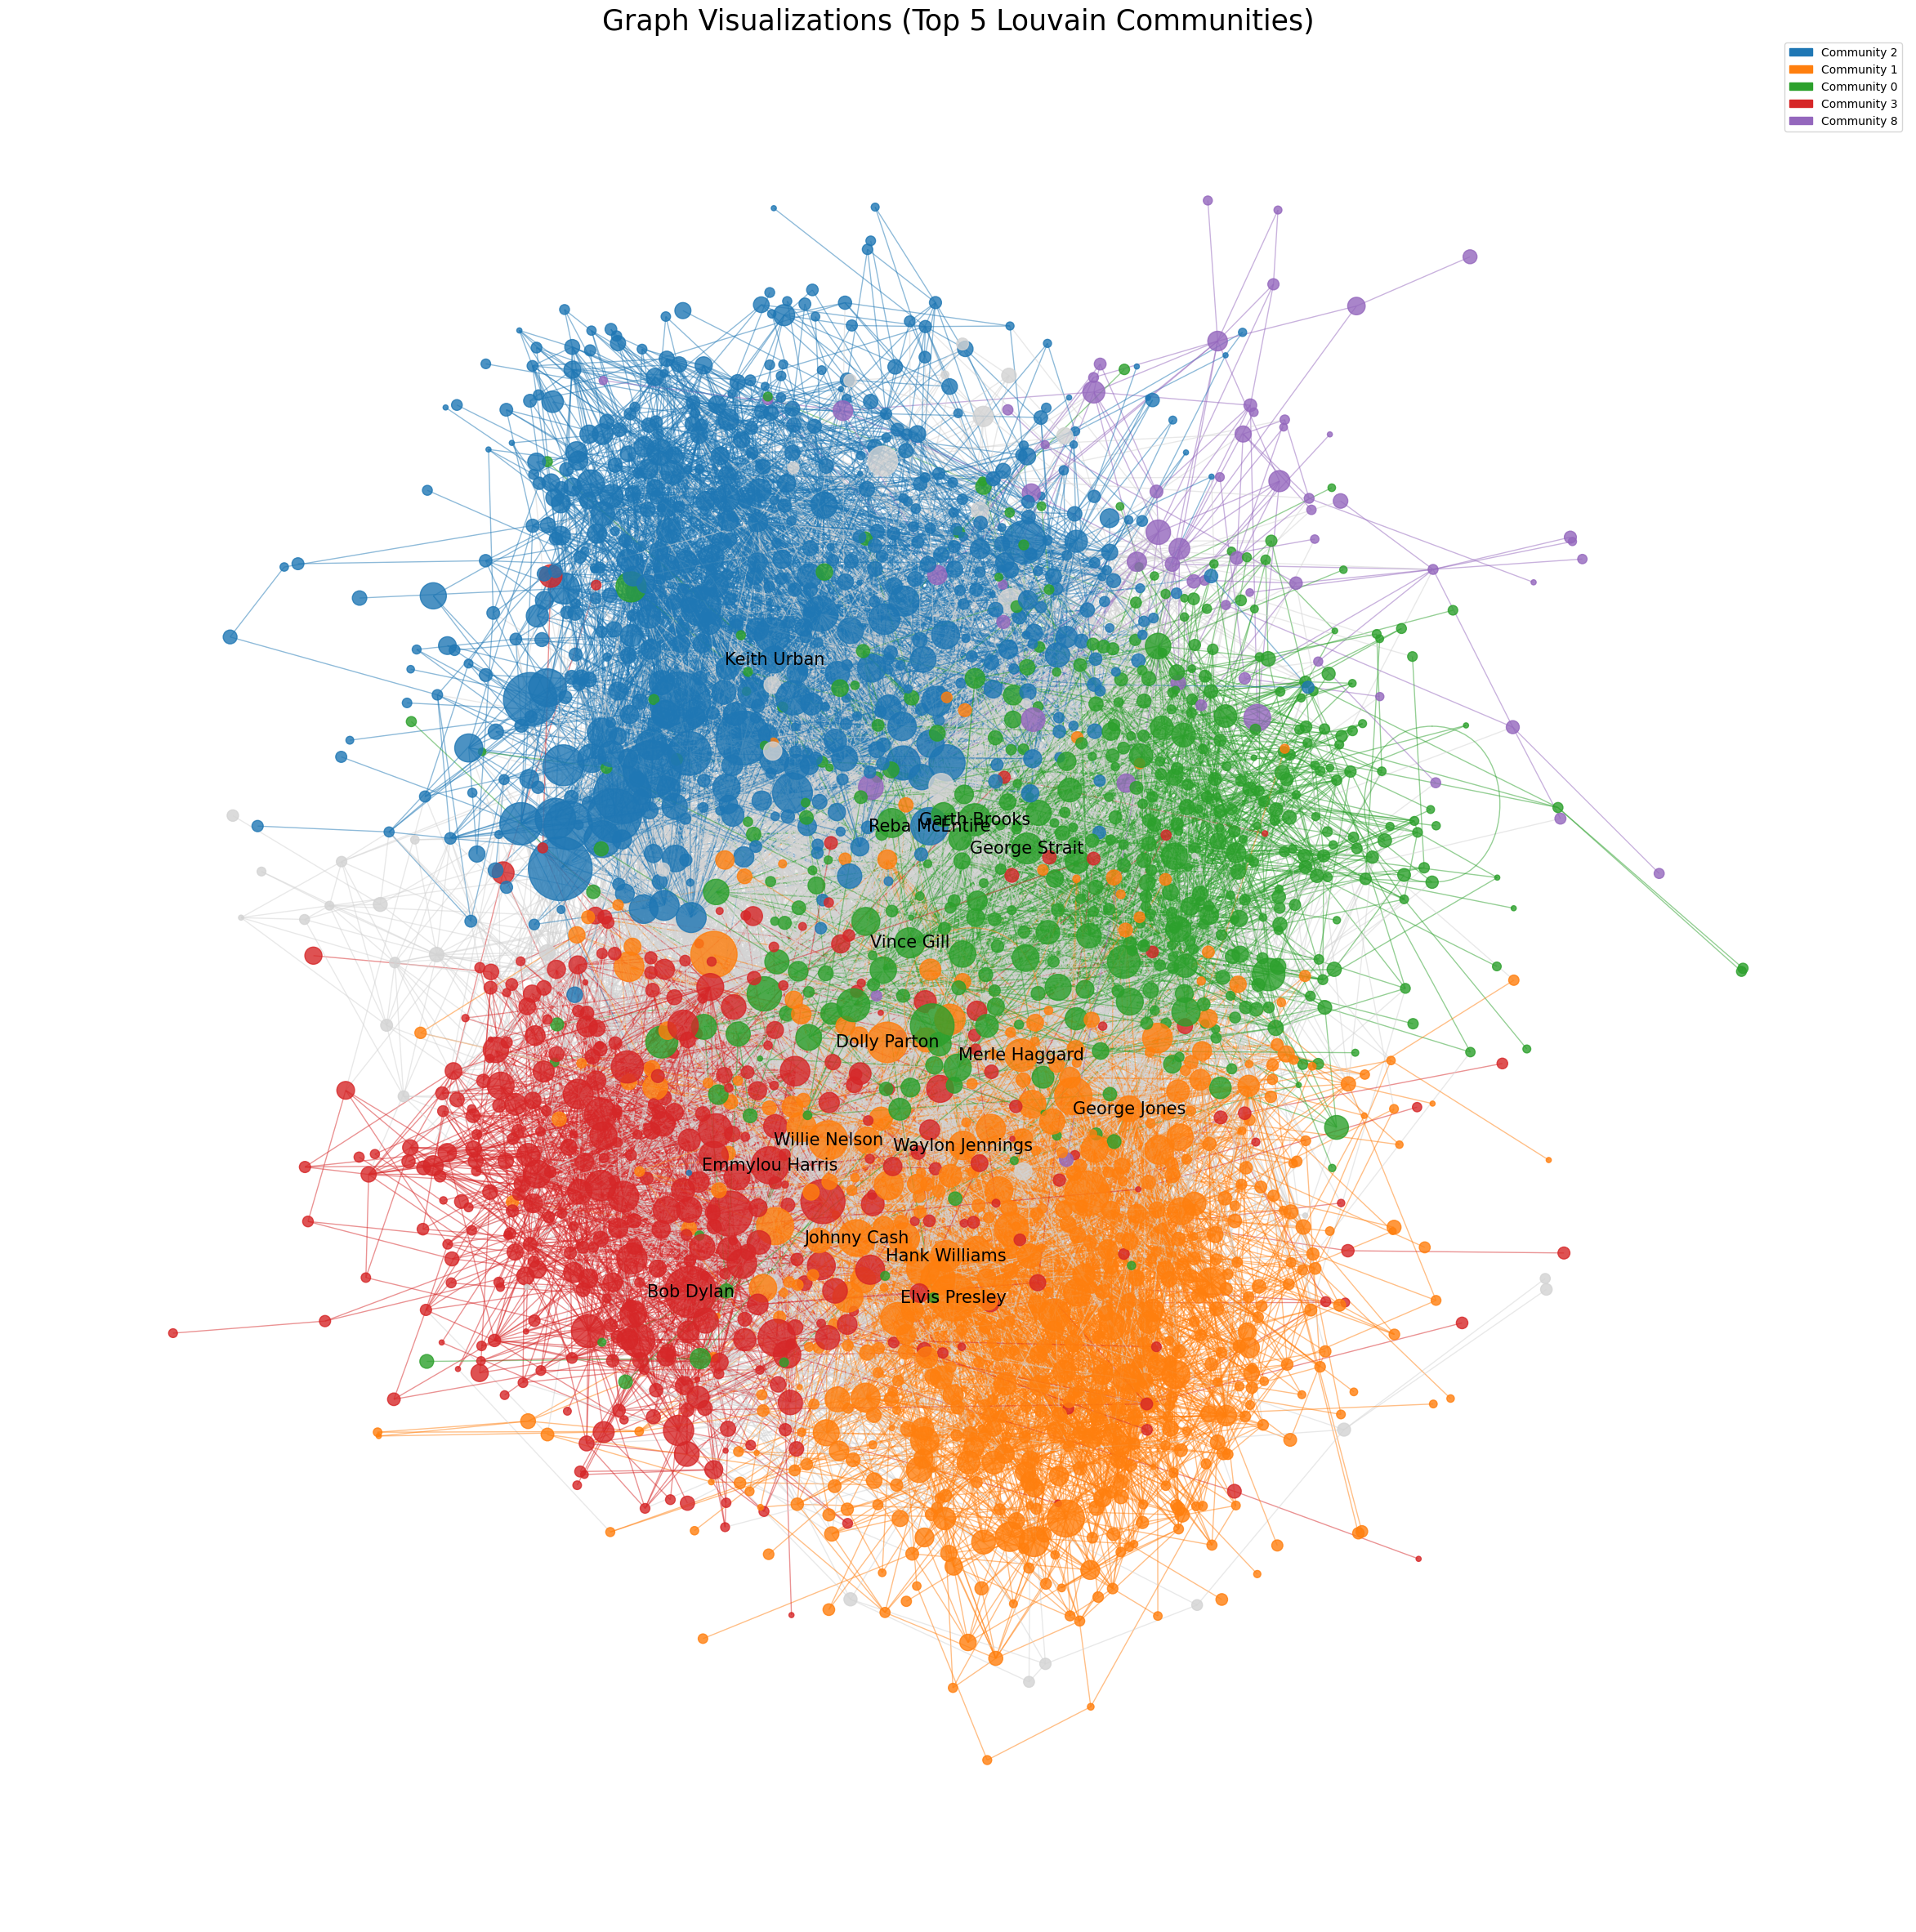

In [30]:
# Initialize ForceAtlas2 for layout generation
forceatlas2 = ForceAtlas2(
    outboundAttractionDistribution=False,
    adjustSizes=False,
    edgeWeightInfluence=0.5,
    jitterTolerance=1, 
    barnesHutOptimize=True,
    barnesHutTheta=0,
    multiThreaded=False,
    scalingRatio=0.000001,
    strongGravityMode=False,
    gravity=0.0001,
    verbose=False
)

# Generate positions using ForceAtlas2
positions = forceatlas2.forceatlas2_networkx_layout(G, pos=None, iterations=100)

# Plot the graph
plt.figure(figsize=(30, 30))

# Draw nodes with colors and sizes based on genre-based communities and word_count
nx.draw_networkx_nodes(
    G, 
    positions, 
    node_color=node_colors, 
    node_size=node_sizes, 
    alpha=0.8
)

# Draw edges with colors based on communities
nx.draw_networkx_edges(G, positions, edge_color=edge_colors, alpha=0.5)

# Label the top 10 artists with the most links
for artist, _ in top_artists:
    x, y = positions[artist]
    plt.text(x, y, artist, fontsize=15, ha='center', va='center', color='black')

# Add legend for top communities
plt.legend(handles=legend_handles, loc='best')
plt.title("Graph Visualizations (Top 5 Louvain Communities)", fontsize=25)
plt.axis('off')
plt.show()


Based on the artists in each cluster, here’s a refined breakdown of the community characteristics:

1. **Blue Community**: Likely represents **modern or pop-influenced country music**. Keith Urban is known for blending country with pop and rock, suggesting this cluster includes artists with contemporary styles.

2. **Red Community**: This community may focus on **folk and Americana** influences. Bob Dylan is an iconic folk and Americana artist, so this cluster could represent artists with strong roots in traditional folk and storytelling.

3. **Orange Community**: This cluster includes **crossover legends** who bridge country, rock, and other genres. Artists like Dolly Parton, Elvis Presley, and Johnny Cash indicate that this community includes influential figures whose work transcends genre boundaries.

4. **Green Community**: Likely represents **traditional or classic country music**. George Strait and Vince Gill are known for their adherence to classic country styles, suggesting this cluster includes artists rooted in traditional country sounds.

5. **Purple Community**: Although not specified by artist names here, the smaller size and relative isolation suggest it may represent a **niche subgenre or lesser-connected artists**, possibly with specialized styles or lesser mainstream influence.

In summary, each community reflects a distinct facet of the country and Americana music landscape, with some artists, like Dolly Parton and Johnny Cash in the orange community, bridging multiple genres and contributing to cross-community connectivity.

# Part 2: TF-IDF to understand genres and communities

## Explain the concept of TF-IDF in your own words and how it can help you understand the genres and communities.

## Calculate and visualize TF-IDF for the genres and communities.

In [32]:
import os
import re
import nltk
from concurrent.futures import ThreadPoolExecutor
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import mwparserfromhell
from collections import Counter

# Ensure NLTK resources are downloaded (run once)
nltk.download('punkt')
nltk.download('wordnet')
nltk.download('stopwords')
from nltk.corpus import stopwords

# Initialize lemmatizer
lemmatizer = WordNetLemmatizer()

# Path to the folder containing performer files
folder_path = '/Users/aya/Desktop/Skole/social_graps/Aya/shared/performer_files'

# Get list of performer files
performer_files = [
    os.path.join(folder_path, filename)
    for filename in os.listdir(folder_path)
    if filename.endswith('.txt')  # Adjust the extension if necessary
]

# Combine default stopwords with custom ones
stop_words = set(stopwords.words('english'))
stop_words.update([
    'one', 'said', 'also', 'first', 'new', 'two', 'like', 'would', 'time', 
    'music', 'album', 'band', 'song', 'songs', 'artist', 'genre', 'year', 
    'years', 'chart', 'billboard', 'released', 'singer', 'group', 'american', 
    'united', 'states', 'may', 'could', 'including', 'many', 'well', 'known',
    'even', 'although', 'however', 'make', 'made', 'way', 'get', 'got', 'take',
    'taken', 'see', 'used', 'say', 'another', 'still', 'since', 'come', 'second',
    'became', 'member', 'members', 'performed', 'performance', 'career', 'born',
    'live', 'known', 'popular', 'best'
])

def extract_genres(wikitext):
    """Extract genres from the wikitext using mwparserfromhell."""
    parsed_wikitext = mwparserfromhell.parse(wikitext)
    templates = parsed_wikitext.filter_templates()
    for template in templates:
        if template.name.lower().startswith('infobox'):
            if template.has('genre'):
                genre_param = template.get('genre').value.strip()
                genre_wikicode = mwparserfromhell.parse(genre_param)
                genre_text = genre_wikicode.strip_code(normalize=True, collapse=True).strip()
                genres = re.split(r'[,\n/|]+', genre_text)
                # Clean up genres
                genres = [
                    genre.strip().lower().replace(' music', '')
                    for genre in genres
                ]
                genres = [genre for genre in genres if genre]
                return genres
    return []

def extract_text(wikitext):
    """Extract plain text from the wikitext using mwparserfromhell."""
    parsed_wikitext = mwparserfromhell.parse(wikitext)
    plain_text = parsed_wikitext.strip_code(normalize=True, collapse=True)
    # Remove URLs and artifacts
    plain_text = re.sub(r'http\S+', '', plain_text)
    artifact_patterns = [
        r'\[\[Category:[^\]]*\]\]', r'\[\[File:[^\]]*\]\]', r'\[\[Image:[^\]]*\]\]',
        r'\{\{[^\}]*\}\}', r'<[^>]+>', r'align(center|left|right)', r'scoperow',
        r'&nbsp;', r'ndash', r'&amp;', r'&quot;', r'&lt;', r'&gt;',
        r'\|', r'\[\[|\]\]',
    ]
    for pattern in artifact_patterns:
        plain_text = re.sub(pattern, '', plain_text, flags=re.IGNORECASE)
    plain_text = re.sub(r'\s+', ' ', plain_text).strip()
    return plain_text

def process_file(file_path):
    """Process a single performer file to extract artist name, genres, and text."""
    with open(file_path, 'r', encoding='utf-8') as file:
        wikitext = file.read()
        genres = extract_genres(wikitext)
        text = extract_text(wikitext)
        # Extract artist name from file path
        filename = os.path.basename(file_path)
        artist_name, _ = os.path.splitext(filename)
        return (artist_name, genres, text)

# Process Performer Files
with ThreadPoolExecutor() as executor:
    results = list(executor.map(process_file, performer_files))

# Initialize mappings
artist_texts = {}
artist_genres = {}
genre_counts = Counter()

for artist_name, genres, text in results:
    artist_texts[artist_name] = text
    artist_genres[artist_name] = genres
    for genre in genres:
        genre_counts[genre] += 1

# Get the top 15 genres
top_15_genres = [genre for genre, count in genre_counts.most_common(15)]
print("Top 15 Genres:", top_15_genres)

# Function to standardize genres
def standardize_genre(genre):
    genre_lower = genre.lower().strip()
    genre_standard = re.sub(r'\s+music$', '', genre_lower)
    return genre_standard

# Build genre communities for the top 15 genres
genre_communities = {genre: [] for genre in top_15_genres}

for artist, genres in artist_genres.items():
    # Standardize genres for the artist
    standardized_genres = [standardize_genre(g) for g in genres]
    # Find genres that are in the top 15
    common_genres = [g for g in standardized_genres if g in top_15_genres]
    # Assign artist to the corresponding genre communities
    for genre in common_genres:
        genre_communities[genre].append(artist)

# Normalize artist names
def normalize_artist_name(name):
    return name.strip().lower().replace('_', ' ').replace('-', ' ')

normalized_artist_texts = {}
for artist_name, text in artist_texts.items():
    normalized_name = normalize_artist_name(artist_name)
    normalized_artist_texts[normalized_name] = text

normalized_genre_communities = {}
for genre, artists in genre_communities.items():
    normalized_artists = [normalize_artist_name(artist) for artist in artists]
    normalized_genre_communities[genre] = normalized_artists

# Function to preprocess text
def preprocess_text(text):
    """Tokenize, remove stop words, and lemmatize the text."""
    tokens = word_tokenize(text)
    tokens = [
        token.lower()
        for token in tokens
        if token.isalpha()
    ]
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words
    ]
    return tokens  # Return tokens

# Step 1: Create TF lists and list top 15 words for each genre
genre_tf = {}

for genre, artists in normalized_genre_communities.items():
    all_tokens = []
    for artist in artists:
        text = normalized_artist_texts.get(artist, "")
        if text:
            tokens = preprocess_text(text)
            all_tokens.extend(tokens)
        else:
            print(f"Warning: Text not found for artist '{artist}' in genre '{genre}'")
    # Compute term frequencies
    word_counts = Counter(all_tokens)
    # Get the top 15 words
    top_15_words = word_counts.most_common(15)
    genre_tf[genre] = top_15_words

# Step 2: For each genre, create a single document consisting of all cleaned text
community_documents = {}

for genre, artists in normalized_genre_communities.items():
    all_texts = []
    for artist in artists:
        text = normalized_artist_texts.get(artist, "")
        if text:
            tokens = preprocess_text(text)
            cleaned_text = ' '.join(tokens)
            all_texts.append(cleaned_text)
        else:
            print(f"Warning: Text not found for artist '{artist}' in genre '{genre}'")
    # Concatenate all cleaned texts for this genre community
    community_document = ' '.join(all_texts)
    community_documents[genre] = community_document


[nltk_data] Downloading package punkt to /Users/aya/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to /Users/aya/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package stopwords to /Users/aya/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


Top 15 Genres: ['country', 'folk', 'americana', 'bluegrass', 'rock', 'pop', 'country rock', 'country pop', 'blues', 'gospel', 'rockabilly', 'alternative country', 'folk rock', 'rock and roll', 'southern rock']



### Genres
#### The logarithm used:

We used $( 1 + \log(\text{TF}))$ to reduce the impact of extremely high term frequencies, making the scores less biased towards very common terms within genres. This adjustment ensures that words with high TF still contribute significantly but are scaled down, allowing more unique, genre-specific words to appear in the top rankings. This approach helps us focus on terms that are distinctive to each genre, rather than just frequent.


In [39]:
import math
from collections import defaultdict

# Step 1: Gather all words across genres to calculate DF
# Create a set of all unique words
all_words = set()
for word_counts in genre_tf.values():
    words = [word for word, count in word_counts]
    all_words.update(words)

# Total number of documents (genres)
N = len(genre_tf)

# Step 2: Calculate Document Frequencies (DF)
word_df = defaultdict(int)  # Default to 0

for word in all_words:
    for genre in genre_tf:
        # Check if the word appears in the genre
        genre_words = set([w for w, count in genre_tf[genre]])
        if word in genre_words:
            word_df[word] += 1

# Calculate IDF for each word
word_idf = {}
for word, df in word_df.items():
    idf = math.log(N / df)
    word_idf[word] = idf

# Step 3: Calculate TF-IDF for each word in each genre, using 1 + log(TF)
genre_tfidf = {}

for genre in genre_tf:
    tfidf_scores = {}
    for word, tf in genre_tf[genre]:
        idf = word_idf[word]
        # Apply 1 + log(TF) transformation to the term frequency
        tf_adjusted = 1 + math.log(tf) if tf > 0 else 0
        tfidf = tf_adjusted * idf
        tfidf_scores[word] = tfidf
    # Sort words by TF-IDF score in descending order
    sorted_tfidf = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)
    genre_tfidf[genre] = sorted_tfidf

# Step 4: List the top 10 words for each genre according to TF-IDF
top_n = 10

for genre in top_15_genres:
    print(f"\nTop {top_n} TF-IDF words for genre '{genre}':")
    top_words = genre_tfidf[genre][:top_n]
    for word, score in top_words:
        print(f"  {word}: {score:.4f}")



Top 10 TF-IDF words for genre 'country':
  artist: 17.4906
  top: 14.0731
  nashville: 11.7477
  u: 11.5287
  love: 8.2019
  date: 8.0706
  hit: 6.7827
  album: 4.4770
  award: 2.8481
  release: 2.0727

Top 10 TF-IDF words for genre 'folk':
  folk: 17.3631
  recording: 5.6329
  guitarist: 5.5551
  vocal: 5.4701
  recorded: 4.6396
  musician: 3.1775
  album: 3.0772
  award: 2.0324
  release: 1.3998
  guitar: 1.3868

Top 10 TF-IDF words for genre 'americana':
  carter: 12.7105
  deville: 12.5005
  blue: 7.3046
  recording: 5.7432
  vocal: 5.7337
  album: 3.2932
  musician: 3.2519
  award: 2.0465
  release: 1.4929
  guitar: 1.4740

Top 10 TF-IDF words for genre 'bluegrass':
  bluegrass: 19.7907
  banjo: 16.4349
  vocal: 5.6997
  date: 5.6540
  guitarist: 5.5316
  recorded: 4.6490
  musician: 3.2775
  album: 3.0904
  award: 2.0048
  guitar: 1.4525

Top 10 TF-IDF words for genre 'rock':
  seger: 16.4178
  sahm: 12.0701
  guitarist: 5.6694
  rock: 4.6897
  recorded: 4.5445
  musician: 3.249


### Output and Descriptiveness:

1. **Country**: Words like "Nashville" and "hit" appear alongside more general terms like "artist," indicating that genre-specific locations and industry terms have strong associations here.

2. **Folk**: The prominent word "folk" accurately represents this genre, with other terms like "guitarist" and "vocal" reflecting the instrumental and vocal nature of folk music.

3. **Americana**: Words like "Carter" and "Deville" point to specific influences and historical figures, which align well with the genre’s roots-oriented style.

4. **Bluegrass**: Distinctive terms like "bluegrass" and "banjo" are appropriately high, capturing this genre’s unique instrumentation.

5. **Rock**: "Seger" and "Sahm" (names of artists associated with rock) rank high, indicating key figures in this genre.

6. **Gospel**: Words like "gospel," "family," and "Carter" reflect the genre's focus on family groups and religious themes.

7. **Rockabilly**: The genre-specific term "rockabilly" is prominent, along with "hall," which might relate to famous music venues associated with this genre.

8. **Alternative Country**: The words "Texas" and "film" may reflect the genre's ties to regional culture and film influences.




#### Wordclouds for genres

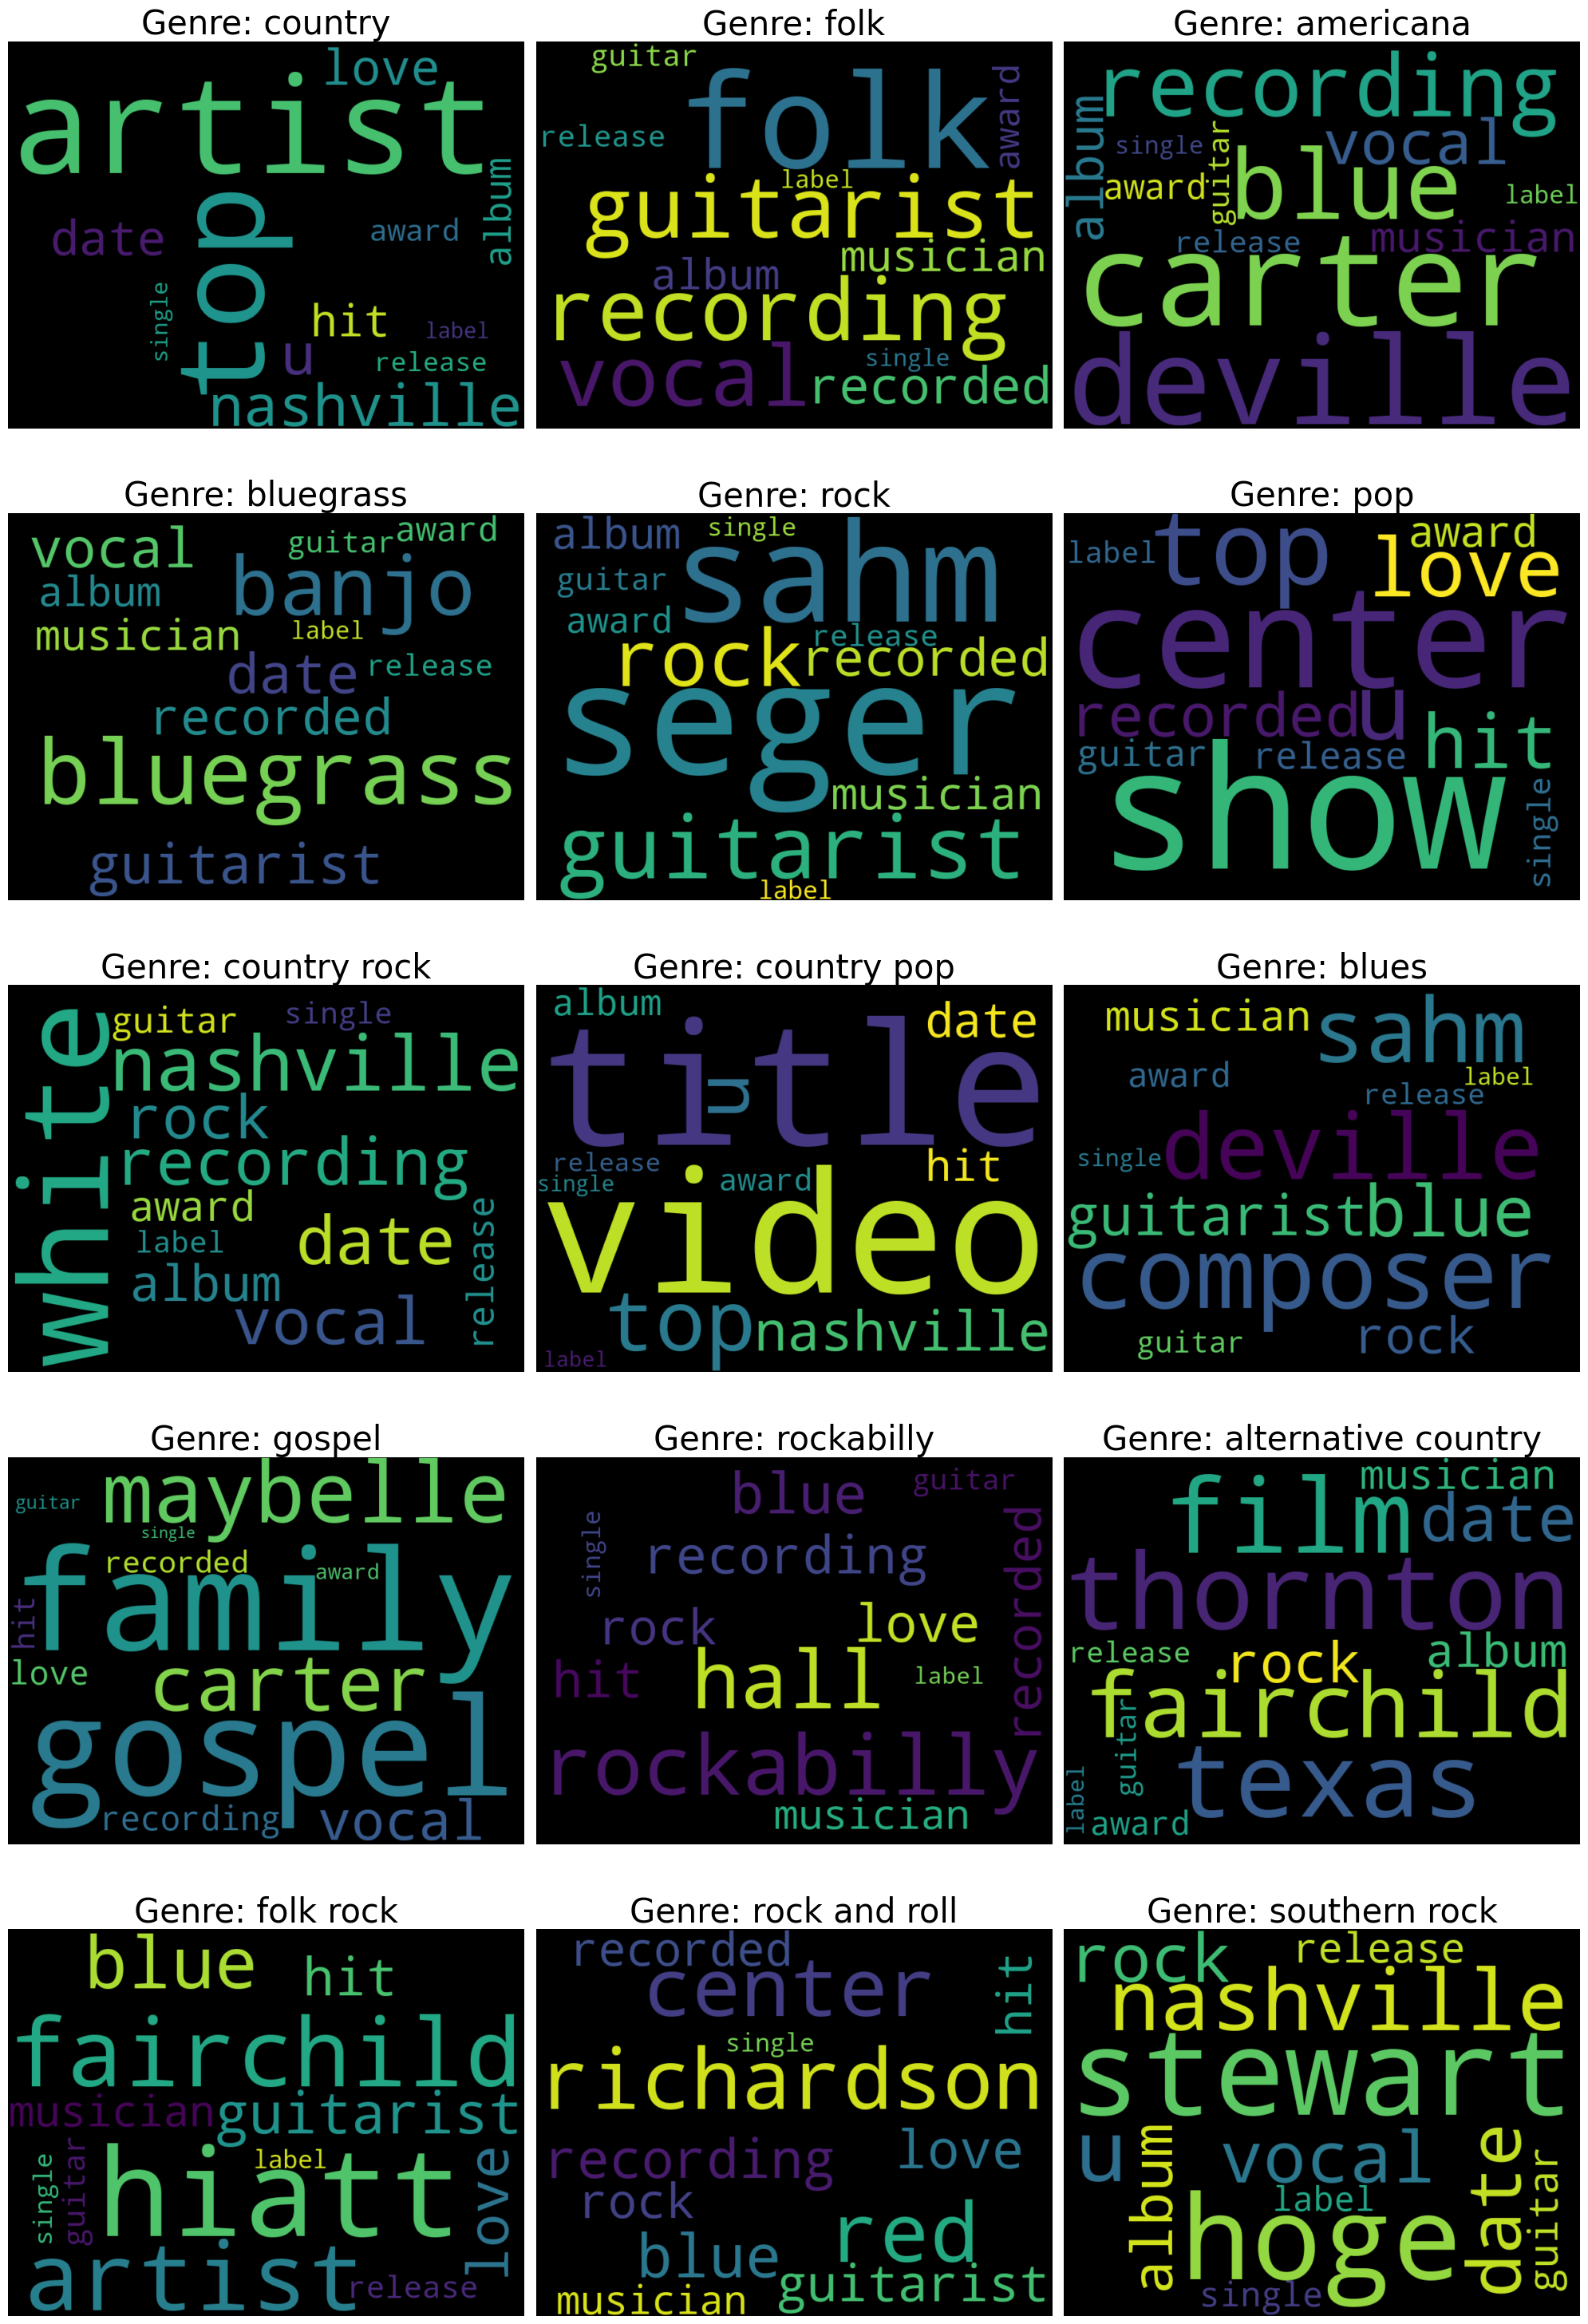

In [37]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'first', 'new', 'two', 'like', 'would', 'time',
    'music', 'album', 'song', 'songs', 'artist', 'genre', 'year',
    'years', 'chart', 'billboard', 'released', 'singer', 'group',
    'may', 'could', 'including', 'many', 'well', 'known',
    'even', 'although', 'however', 'make', 'made', 'way', 'get', 'got', 'take',
    'taken', 'see', 'used', 'say', 'another', 'still', 'since', 'come', 'second',
    'became', 'member', 'members', 'performed', 'career', 'born',
    'known', 'popular', 'best'
])

# Prepare the TF-IDF data for word clouds
genre_tfidf_dict = {}
for genre in genre_tfidf:
    tfidf_scores = dict(genre_tfidf[genre])
    genre_tfidf_dict[genre] = tfidf_scores

# Determine the number of genres to display
top_genres = top_15_genres  # This should be the list of your top 15 genres

# Set up the subplot grid dimensions
num_genres = len(top_genres)
cols = 3  # Adjust the number of columns as needed
rows = (num_genres + cols - 1) // cols

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 6 * rows))

# Flatten axes array for easy iteration
if num_genres == 1:
    axes = [axes]  # Ensure axes is iterable when there's only one subplot
else:
    axes = axes.flatten()

# Generate and plot the word clouds
for idx, genre in enumerate(top_genres):
    tfidf_scores = genre_tfidf_dict.get(genre, {})
    # Exclude words with zero or negative TF-IDF scores
    tfidf_scores = {word: score for word, score in tfidf_scores.items() if score > 0}
    wordcloud = WordCloud(
        width=800,
        height=600,
        background_color='black',
        stopwords=custom_stopwords,
        colormap='viridis'
    ).generate_from_frequencies(tfidf_scores)
    
    # Plot the word cloud in the corresponding subplot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f"Genre: {genre}", fontsize=30)
    
# Remove any empty subplots
for i in range(idx + 1, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()


The word clouds provide a clearer picture of each genre’s unique characteristics by emphasizing terms that are both common within the genre and distinctive compared to others. Here are the main takeaways:

- **Country** stands out with terms like "Nashville," highlighting its geographical roots, along with industry-focused words such as "artist" and "hit," which underscore the genre's mainstream popularity.
  
- **Folk** emphasizes acoustic instrumentation and storytelling with words like "folk," "guitarist," and "recording," reflecting its raw, authentic style.

- **Americana** and **Bluegrass** capture their traditional roots with terms like "Carter" and "Deville" in Americana and "bluegrass" and "banjo" in Bluegrass, illustrating their heritage and signature instrumentation.

- **Rock** and **Rockabilly** feature influential names ("Seger," "Sahm") and terms like "rock," reflecting their core musical styles. Rockabilly also highlights its dancehall culture with "hall."

- **Pop** shows its performance-centered and visual culture with terms like "show," "center," and "video," pointing to its media appeal.

- **Country Rock** and **Country Pop** blend elements from both genres, with terms like "Nashville" and "rock" in Country Rock and "title" and "video" in Country Pop, indicating a mix of country roots with mainstream appeal.

- **Blues** and **Gospel** focus on soulful elements. Blues highlights musical composition with words like "composer," while Gospel centers on family and faith, as shown by terms like "family" and "gospel."

- **Alternative Country** and **Southern Rock** capture regional and cultural influences. Alternative Country includes terms like "Texas" and "film," hinting at a cinematic quality, while Southern Rock features artists associated with Southern roots.

- **Folk Rock** and **Rock and Roll** combine folk and rock elements, with terms like "Hiatt" in Folk Rock pointing to influential figures and "center" in Rock and Roll emphasizing its performance-based nature.


### Communities

#### TF-IDF Calculations

In [41]:
import math
from collections import defaultdict, Counter
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

# Assuming necessary libraries like nltk are already set up
lemmatizer = WordNetLemmatizer()
stop_words = set(stopwords.words("english"))

def normalize_artist_name(name):
    return name.strip().lower().replace('_', ' ').replace('-', ' ')

# Normalize artist names in artist_texts
normalized_artist_texts = {}
for artist_name, text in artist_texts.items():
    normalized_name = normalize_artist_name(artist_name)
    normalized_artist_texts[normalized_name] = text

# Normalize artist names in structural communities
normalized_structural_communities = {}
for community_id, artists in structural_communities.items():
    normalized_artists = [normalize_artist_name(artist) for artist in artists]
    normalized_structural_communities[community_id] = normalized_artists

# Function to preprocess text
def preprocess_text(text):
    tokens = word_tokenize(text)
    tokens = [
        token.lower()
        for token in tokens
        if token.isalpha()
    ]
    tokens = [
        lemmatizer.lemmatize(token)
        for token in tokens
        if token not in stop_words
    ]
    return tokens  # Return tokens for TF calculation

# Aggregate texts and compute TF for each community
community_tf = {}

for community_id, artists in normalized_structural_communities.items():
    all_tokens = []
    for artist in artists:
        text = normalized_artist_texts.get(artist, "")
        if text:
            tokens = preprocess_text(text)
            all_tokens.extend(tokens)
        else:
            print(f"Warning: Text not found for artist '{artist}' in community '{community_id}'")
    # Compute term frequencies
    word_counts = Counter(all_tokens)
    community_tf[community_id] = word_counts  # Stores Counter objects

# Total number of documents (communities)
N = len(community_tf)

# Calculate Document Frequencies (DF)
word_df = defaultdict(int)

# Create a set of all unique words
all_words = set()
for word_counts in community_tf.values():
    all_words.update(word_counts.keys())

for word in all_words:
    df = sum(1 for community in community_tf if word in community_tf[community])
    word_df[word] = df

# Calculate IDF for each word
word_idf = {}
for word, df in word_df.items():
    idf = math.log(N / df)
    word_idf[word] = idf

# Calculate TF-IDF for each word in each community using 1 + log(TF)
community_tfidf = {}

for community_id, tf_counts in community_tf.items():
    tfidf_scores = {}
    for word, tf in tf_counts.items():
        idf = word_idf[word]
        # Apply 1 + log(TF) transformation to term frequency
        tf_adjusted = 1 + math.log(tf) if tf > 0 else 0
        tfidf = tf_adjusted * idf
        tfidf_scores[word] = tfidf
    # Sort words by TF-IDF score in descending order
    sorted_tfidf = sorted(tfidf_scores.items(), key=lambda x: x[1], reverse=True)
    community_tfidf[community_id] = sorted_tfidf

# Output the top N TF-IDF words for each community
top_n = 10

for community_id in sorted(community_tfidf.keys()):
    print(f"\nTop {top_n} TF-IDF words for community '{community_id}':")
    top_words = community_tfidf[community_id][:top_n]
    for word, score in top_words:
        print(f"  {word}: {score:.4f}")



Top 10 TF-IDF words for community '0':
  lemaire: 10.5119
  foust: 10.5119
  willé: 10.2469
  stokley: 9.5188
  supernaw: 9.0866
  navaira: 9.0866
  lundquist: 8.9889
  prout: 8.7795
  cornelison: 8.7795
  olander: 8.6668

Top 10 TF-IDF words for community '1':
  millhouse: 11.3006
  biram: 10.6096
  copas: 10.2469
  hawkshaw: 10.2469
  wakely: 10.2469
  goldsboro: 10.1898
  bopper: 10.0710
  bowersox: 10.0710
  drusky: 10.0091
  bri: 9.5188

Top 10 TF-IDF words for community '2':
  bergling: 13.3758
  mccreery: 12.5844
  bice: 12.0598
  rexha: 11.7979
  mccurdy: 11.6542
  tedder: 11.3352
  marshmello: 11.1565
  annies: 10.9208
  bradbery: 10.7031
  bieber: 10.6419

Top 10 TF-IDF words for community '3':
  thile: 12.2489
  hackensaw: 10.8790
  danko: 10.3568
  ibbotson: 10.3568
  duffey: 10.3025
  mceuen: 10.1312
  worsnop: 10.1312
  matsson: 10.1312
  dement: 10.0710
  mccue: 9.9454

Top 10 TF-IDF words for community '4':
  wystrach: 8.5480
  duddy: 6.1532
  bougainvillea: 3.7202
  o


1. **Community Specialization**:
   - **Community 0**: Dominated by names like "lemaire" and "foust," likely representing niche or lesser-known artists that define this group.
   - **Community 1**: Features artists like "biram" and "copas," suggesting a distinct subset of artists that are perhaps associated with a specific musical tradition.
   - **Community 2**: Includes well-known modern names such as "bieber" and "mccreery," indicating a possible pop or mainstream influence.
   - **Community 3**: Terms like "thile" and "hackensaw" hint at folk or roots music influences, suggesting an Americana or bluegrass focus.
   - **Community 4**: Contains words like "wystrach" and "duddy," which may reflect a specific, possibly regional subset of country music.
   - **Community 5**: Unique terms like "plato" and "hippielovepunk" indicate a strong alternative or indie influence within this community.
   - **Community 6**: Names such as "carmack" and "panettiere" might reflect crossover or TV-associated artists, possibly linked to Nashville or the entertainment industry.
   - **Community 7**: Contains historical or vintage terms like "roba" and "arkansaw," suggesting roots or traditional American music.
   - **Community 8**: Australian-themed names like "kernaghan" and "blundell" imply this community may represent Australian country or folk music.


#### Wordclouds for Communities

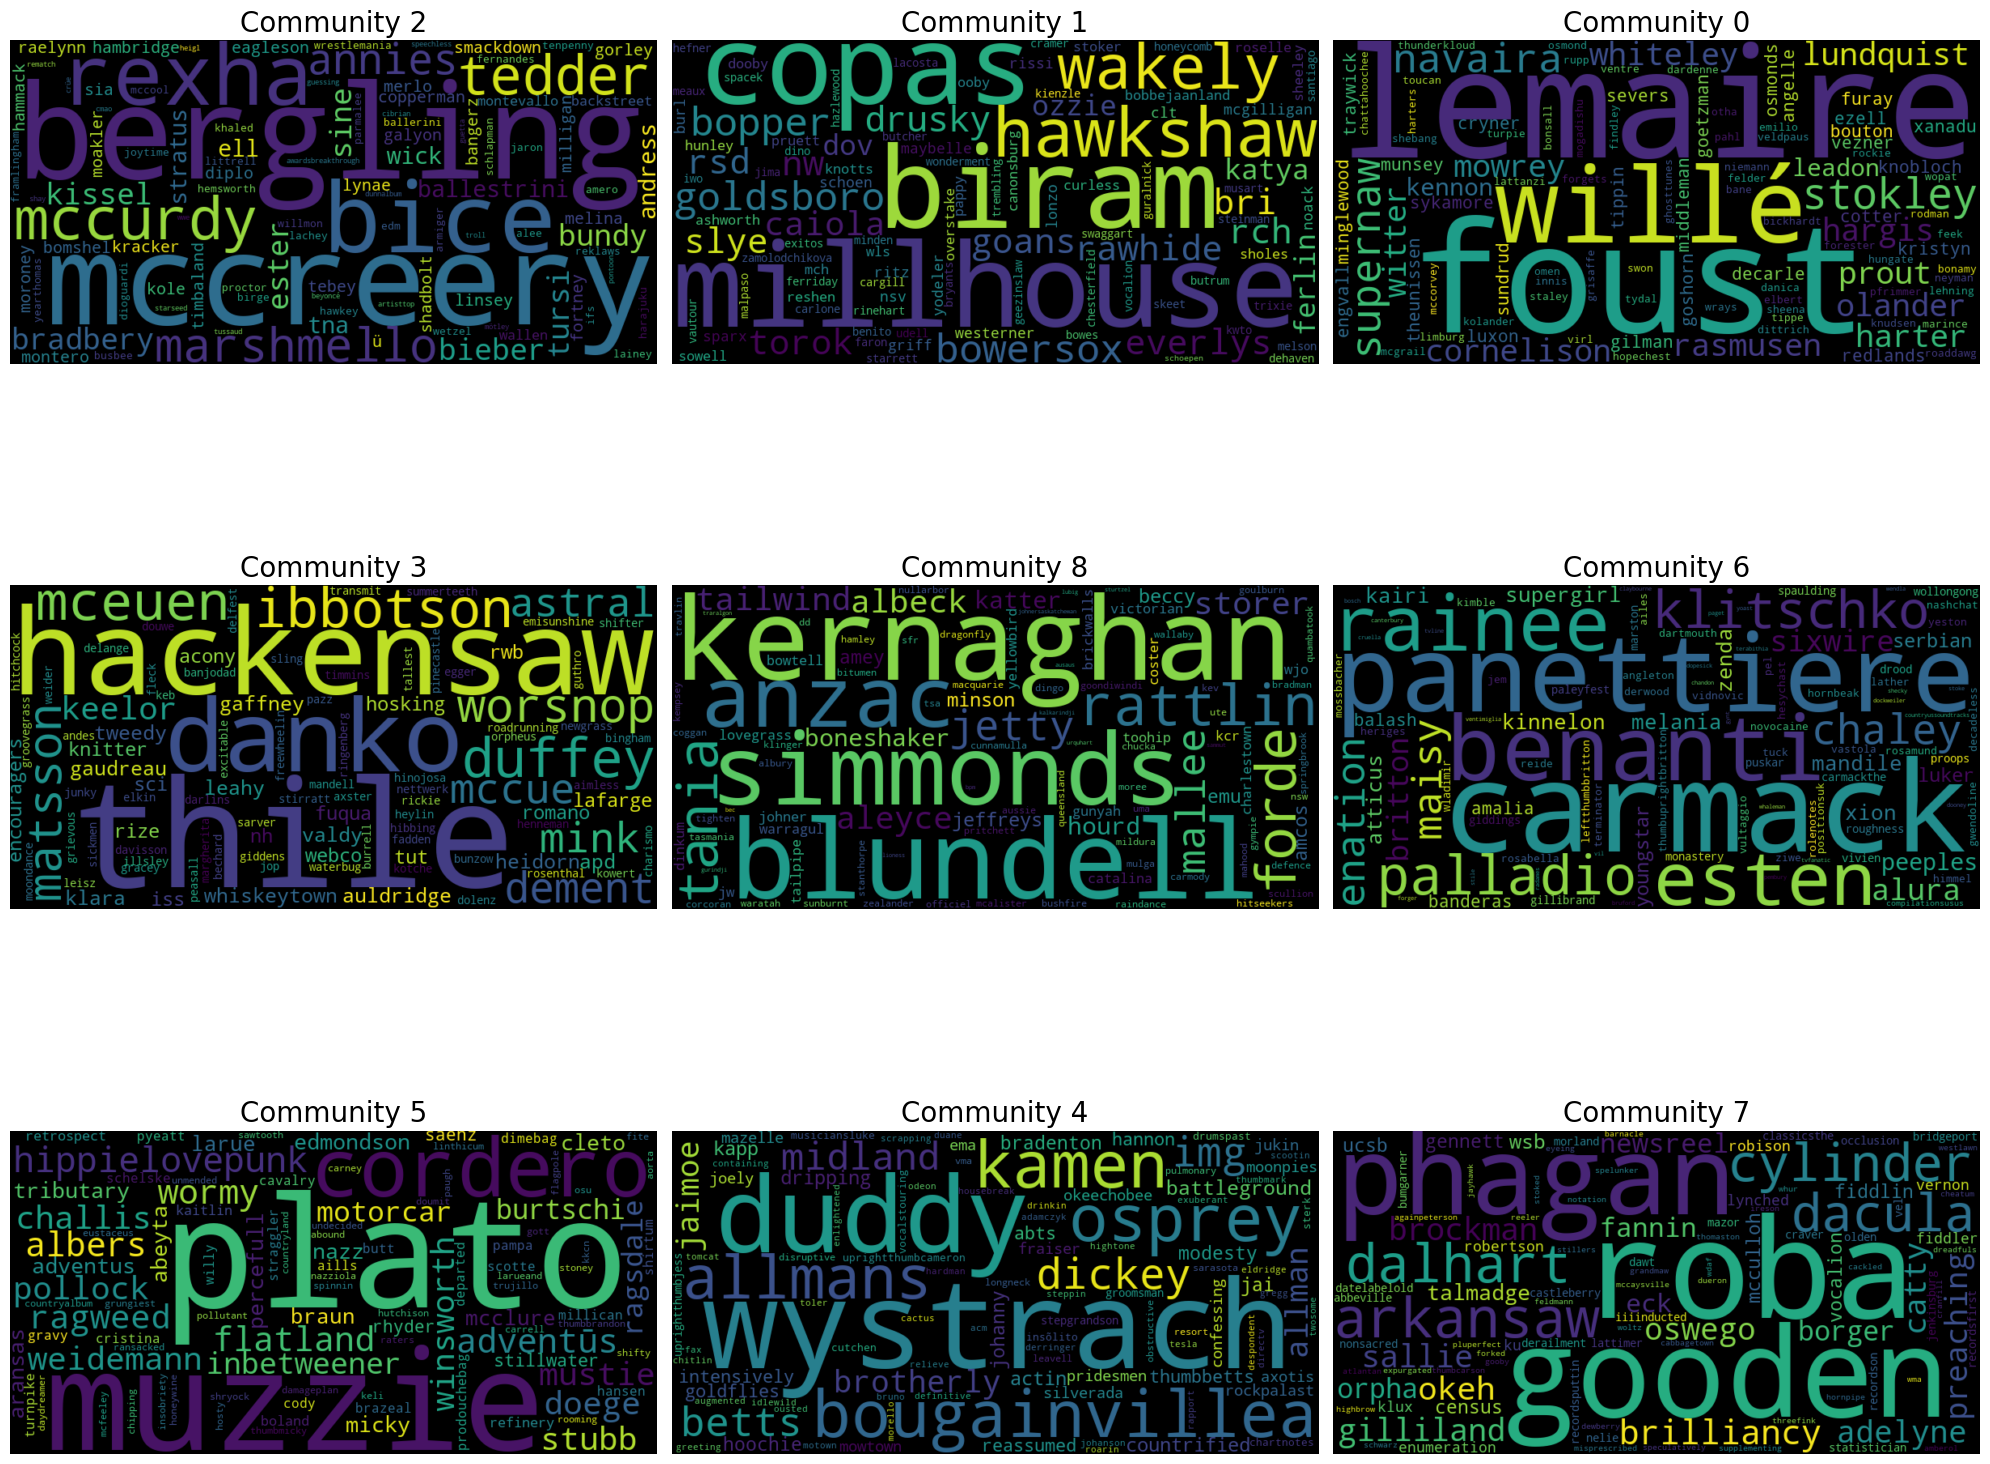

In [45]:
import matplotlib.pyplot as plt
from wordcloud import WordCloud, STOPWORDS

# Define custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update([
    'one', 'said', 'also', 'first', 'new', 'two', 'like', 'would', 'time', 
    'music', 'album', 'band', 'song', 'songs', 'artist', 'genre', 'year', 
    'years', 'chart', 'billboard', 'released', 'singer', 'group', 'american', 
    'united', 'states', 'may', 'could', 'including', 'many', 'well', 'known',
    'even', 'although', 'however', 'make', 'made', 'way', 'get', 'got', 'take',
    'taken', 'see', 'used', 'say', 'another', 'still', 'since', 'come', 'second',
    'became', 'member', 'members', 'performed', 'performance', 'career', 'born',
    'live', 'known', 'popular', 'best'
])

# Prepare the TF-IDF data for word clouds
community_tfidf_dict = {community_id: dict(community_tfidf[community_id]) for community_id in community_tfidf}

# Determine the number of communities to display in order of size
community_sizes = {community_id: len(artists) for community_id, artists in normalized_structural_communities.items()}
sorted_communities = sorted(community_sizes.items(), key=lambda x: x[1], reverse=True)
top_N = 10  # Adjust as needed
top_communities = [community_id for community_id, size in sorted_communities[:top_N]]

# Set up the subplot grid dimensions
num_communities = len(top_communities)
cols = 3  
rows = (num_communities + cols - 1) // cols

# Create the subplots
fig, axes = plt.subplots(rows, cols, figsize=(20, 6 * rows))

# Flatten axes array for easy iteration
axes = axes.flatten()

# Generate and plot the word clouds in sorted order
for idx, community_id in enumerate(top_communities):
    tfidf_scores = community_tfidf_dict[community_id]
    # Exclude words with zero or negative TF-IDF scores
    tfidf_scores = {word: score for word, score in tfidf_scores.items() if score > 0}
    wordcloud = WordCloud(
        width=800,
        height=400,
        background_color='black',
        stopwords=custom_stopwords,
        colormap='viridis',
        max_words=100
    ).generate_from_frequencies(tfidf_scores)
    
    # Plot the word cloud in the corresponding subplot
    axes[idx].imshow(wordcloud, interpolation='bilinear')
    axes[idx].axis('off')
    axes[idx].set_title(f"Community {community_id}", fontsize=20)

# Remove any empty subplots
for i in range(num_communities, len(axes)):
    fig.delaxes(axes[i])

# Adjust layout
plt.tight_layout()
plt.show()


1. **Community 2**: Dominated by names like "bergling" (Avicii), "mccreery" (Scotty McCreery), and "bieber" (Justin Bieber), this community appears to be centered around contemporary pop and crossover country artists, indicating a blend of mainstream and pop-country influences.

2. **Community 1**: Key terms include "copas," "wakely," and "millhouse," suggesting a focus on classic or traditional country artists, possibly those with historical significance in the genre. This community likely represents roots in early country music.

3. **Community 0**: Words like "lemaire," "foust," and "supernaw" dominate, which might point to a more niche or obscure set of country artists. This community could represent a specific sub-genre or less mainstream area of country music.

4. **Community 3**: Featuring names like "hackensaw," "thile" (Chris Thile), and "danko," this community seems focused on folk, bluegrass, or Americana influences, highlighting artists known for acoustic instrumentation and traditional American music styles.

5. **Community 8**: Names like "kernaghan" and "blundell" suggest a connection to Australian country music, as these artists are prominent in that scene. Other terms like "anzac" reinforce an Australian cultural influence within this community.

6. **Community 6**: With names like "carmack" and "panettiere" (Hayden Panettiere), this community may have a crossover with entertainment or pop-culture figures associated with country music. It could reflect artists linked to television or film, possibly through shows like *Nashville*.

7. **Community 5**: Dominated by unique terms like "plato" and "hippielovepunk," this community likely represents alternative or indie country influences. The presence of such specific and distinctive terms suggests a focus on non-mainstream or experimental elements within country music.

8. **Community 4**: Words like "wystrach" and "duddy" point towards a distinct but perhaps lesser-known set of artists. This community might include emerging or regionally popular figures in the country music scene.

9. **Community 7**: Featuring historical terms like "phagan," "dalhart," and "gooden," this community seems oriented around vintage or early country music. Words like "cylinder" and "okeh" (an early record label) hint at connections to the early days of recorded music.

### Summary
Each community’s word cloud reflects a different aspect of country and related genres, from modern and mainstream artists (Community 2) to classic roots (Community 1 and Community 7), regional influences (Community 8), alternative and indie styles (Community 5), and even connections to the entertainment industry (Community 6). These visualizations reveal a rich diversity within the genre, capturing both historical roots and contemporary cross-genre influences.